In [1]:
import pandas as pd
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio,structural_similarity,normalized_root_mse,hausdorff_distance,normalized_mutual_information
import os

In [2]:
i=3
images_list=sorted(glob("./raw_data/26Jan/camera/11_13_03/*.png"))
camera_data_clean=[x.split("/")[-1].split(".")[0] for x in images_list]
camera_data_clean=[x.split("_")[0]+"."+x.split("_")[1] for x in camera_data_clean]
camera_timestamps=np.array(camera_data_clean,np.float128)

In [3]:
camera_tared=camera_timestamps-camera_timestamps[0]

In [4]:
camera_tared

array([ 0.        ,  0.99424696,  2.84464068,  2.95866537,  3.98092413,
        5.84666728,  5.96780157,  6.96229887,  7.9651599 ,  8.97465611,
       10.85396288, 11.02811671, 11.96028424, 12.96238947, 14.01364708,
       15.82416058, 15.96001959, 16.99561787, 17.96067524, 18.97725725,
       19.96817589, 20.98617888, 21.98392582, 22.98216152, 23.99704123,
       24.95987177, 25.95721102, 26.97281552, 27.988935  , 28.99591828,
       29.98825312, 30.97264862, 31.99456644, 32.98844862, 33.97993946,
       34.971416  , 35.9586916 , 36.96932268, 37.96512413], dtype=float128)

In [5]:
#df=pd.read_csv(glob("./processed_data/Nov_21/"+str(i)+"/*_sync.csv")[0])
df=pd.read_csv("/home/uwr/Desktop/26Jan_2024_01_26_16_26_18_sync.csv")

In [6]:
times=np.array(df["Timestamp"]-df["Timestamp"][0],np.float128)

In [7]:
times_tared=times/np.power(10,9)

In [8]:
times_tared

array([ 0.        ,  0.11012028,  0.20212867,  0.37058098,  0.47046376,
        0.54982054,  0.71026617,  0.86051189,  0.93083867,  1.10044029,
        1.20315991,  1.29076367,  1.46032931,  1.56096231,  1.66020016,
        1.82027563,  1.93012339,  2.02086326,  2.17111239,  2.29023926,
        2.36117268,  2.55120207,  2.65197718,  2.75070326,  2.91124502,
        3.0104024 ,  3.11057607,  3.2802935 ,  3.39055881,  3.49147198,
        3.64072759,  3.75129772,  3.84053105,  4.00097778,  4.12086046,
        4.21047985,  4.37132109,  4.48086827,  4.57063203,  4.7405577 ,
        4.80100703,  4.93057609,  5.10124642,  5.20043052,  5.30103805,
        5.46070685,  5.58058542,  5.60124881,  5.83076307,  5.9398135 ,
        6.03023124,  6.45001959,  6.55033631,  6.65002566,  6.69995827,
        6.83444403,  6.92573365,  7.11969125,  7.28035618,  7.39097218,
        7.50018913,  7.61045859,  7.75059272,  7.84979266,  8.01111644,
        8.12058718,  8.20970457,  8.37037074,  8.50092466,  8.57

In [9]:
lst=[]
lst2=[]#To get camera positions as well
for x in times_tared:
    lst.append(np.argmin(np.abs(camera_tared-x)))

In [10]:
len(lst)

246

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

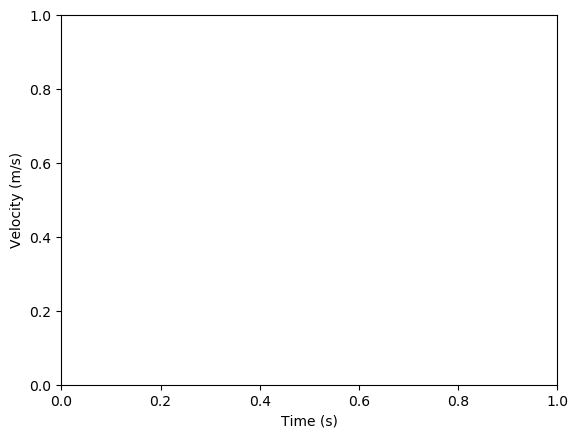

In [11]:
def create_v_d(accs,imus):
    vels=[]
    prev_time=imus.iloc[0]["Timestamp"]/np.power(10,9)
    bias=imus.iloc[0][accs]
    prev_acc=0
    prev_vel=0
    for x in imus.iloc:
    
            #Avg acc * dt = dv
        vel_d=0.5*(prev_acc+x[accs]-bias)*(x["Timestamp"]/np.power(10,9)-prev_time)
        vel=prev_vel+vel_d
        prev_vel=vel
        prev_time=x["Timestamp"]/np.power(10,9)
        vels.append(vel)
    plt.figure()
    plt.ylabel("Velocity (m/s)")
    plt.xlabel("Time (s)")
    plt.plot(imus.iloc[:]["Timestamp"],vels)
    i=0
    prev_s=0
    prev_time=imus.iloc[0]["Timestamp"]/np.power(10,9)
    dists=[]
    for x in imus.iloc:
    
            #Avg acc * dt = dv
        s=prev_s+vels[i]*(x["Timestamp"]/np.power(10,9)-prev_time)+0.5*0.5*(prev_acc+x[accs]-bias)*np.square(x["Timestamp"]/np.power(10,9)-prev_time)
        prev_s=s
        prev_vel=vel
        prev_time=x["Timestamp"]/np.power(10,9)
        dists.append(s)
        i+=1
    plt.figure()
    plt.ylabel("Displacement (m)")
    plt.xlabel("Time (s)")
    plt.plot(imus.iloc[:]["Timestamp"],dists)
    return vels,dists
z_v,z_d=create_v_d("IMU_Linear_Acc_Z",df)
y_v,y_d=create_v_d("IMU_Linear_Acc_Y",df)
x_v,x_d=create_v_d("IMU_Linear_Acc_X",df)

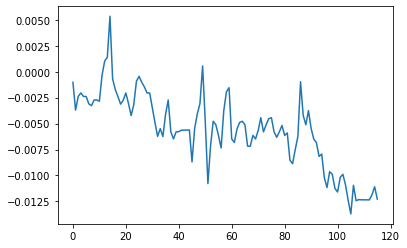

In [274]:
plt.plot(df.iloc[:]["Pose_Y"])

In [13]:
z_d=df["Pose_X"]*-1
z_d

0      0.000038
1      0.001689
2      0.003412
3      0.007141
4      0.008560
         ...   
241    1.308947
242    1.308401
243    1.314371
244    1.319125
245    1.321994
Name: Pose_X, Length: 246, dtype: float64

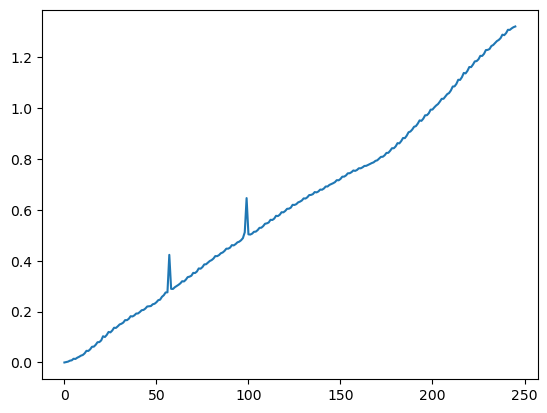

In [31]:
plt.plot(z_d)

In [82]:
l2=[]
for x in range(0,len(z_d)):
    for y in range(x+1,len(z_d)):
        if(np.abs(z_d[y]-z_d[x])>0.95):
            l2.append((x,y))
            break
compare=l2[0]
l3=[compare]
l4=[compare[0]]
for x in l2[1:]:
    if(compare[1]==x[0]):
        compare=x
        l3.append(x)
        l4.append(x[0])

In [83]:
l4

[0]

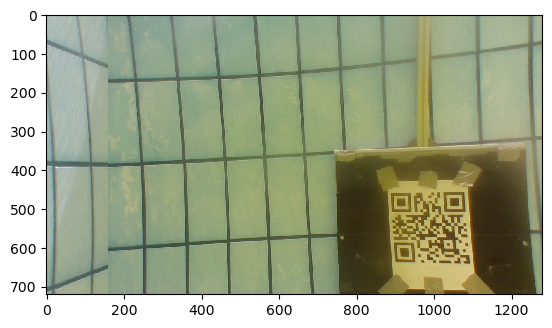

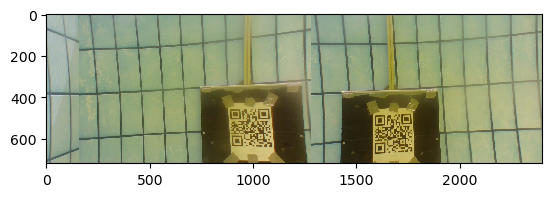

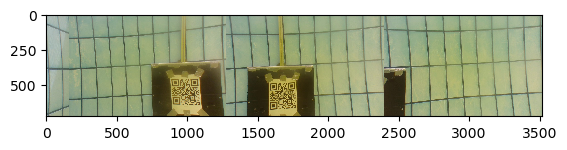

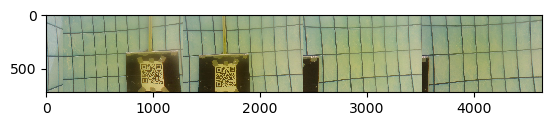

In [79]:
img=cv2.imread(images_list[0])
percentage=0.25
img_first=img[:,:int(640*percentage)]
#plt.figure()
#plt.imshow(img_first)
for x in l4[1:len(l4)]:
    #print(images_list[lst[x]])
    img=cv2.imread(images_list[lst[x]])
    img=img[:,int(640*(percentage)):]
    plt.figure()
    img_first=np.hstack([img_first,img])
    plt.imshow(img_first)

In [43]:
def img_metrics(mosaic,ref_image,crop_min_h=100,crop_max_h=400):
    mosaic=cv2.resize(mosaic[crop_min_h:crop_max_h,:],(ref_image.shape[1],ref_image.shape[0]))
    ssim=structural_similarity(mosaic,ref_image,channel_axis=2,gaussian_weights=True,data_range=255)
    psnr=peak_signal_noise_ratio(mosaic,ref_image)
    nrmse=normalized_root_mse(mosaic,ref_image)
    hd=hausdorff_distance(mosaic,ref_image)
    nmi=normalized_mutual_information(mosaic,ref_image)
    return ssim,psnr,hd,nrmse,nmi
def image_mosaic(min_dist,percentage):
    l2=[]
    for x in range(0,len(z_d)):
        for y in range(x+1,len(z_d)):
            if(np.abs(z_d[y]-z_d[x])>min_dist):
                l2.append((x,y))
                break
    compare=l2[0]
    l3=[compare]
    l4=[compare[0]]
    print(l2)
    for x in l2[1:]:
        if(compare[1]==x[0]):
            compare=x
            l3.append(x)
            l4.append(x[0])
            #l4.append(x[1])
    #print(len(images_list))
    img=cv2.imread(images_list[0])
    img_first=img[:,:int(640*percentage)]
    #plt.figure()
    #plt.imshow(img_first)
    for x in l4[1:len(l4)]:
        #print(images_list[lst[x]])
        img=cv2.imread(images_list[lst[x]])
        img=img[:,int(640*(percentage)):]
        #plt.figure()
        img_first=np.hstack([img_first,img])
        #plt.imshow(img_first)
    return img_first
        
#img_last=cv2.imread(images_list[-1])
#img_last=cv2.imread(images_list[-1])
#plt.imshow(img_last[:,640//4:])   
#img_first=np.hstack(img_first,img_last) 

In [44]:
ref_image[:,:int(640*0.)].shape

(720, 0, 3)

In [45]:
ref_image[:,int(640*0.8):].shape

(720, 768, 3)

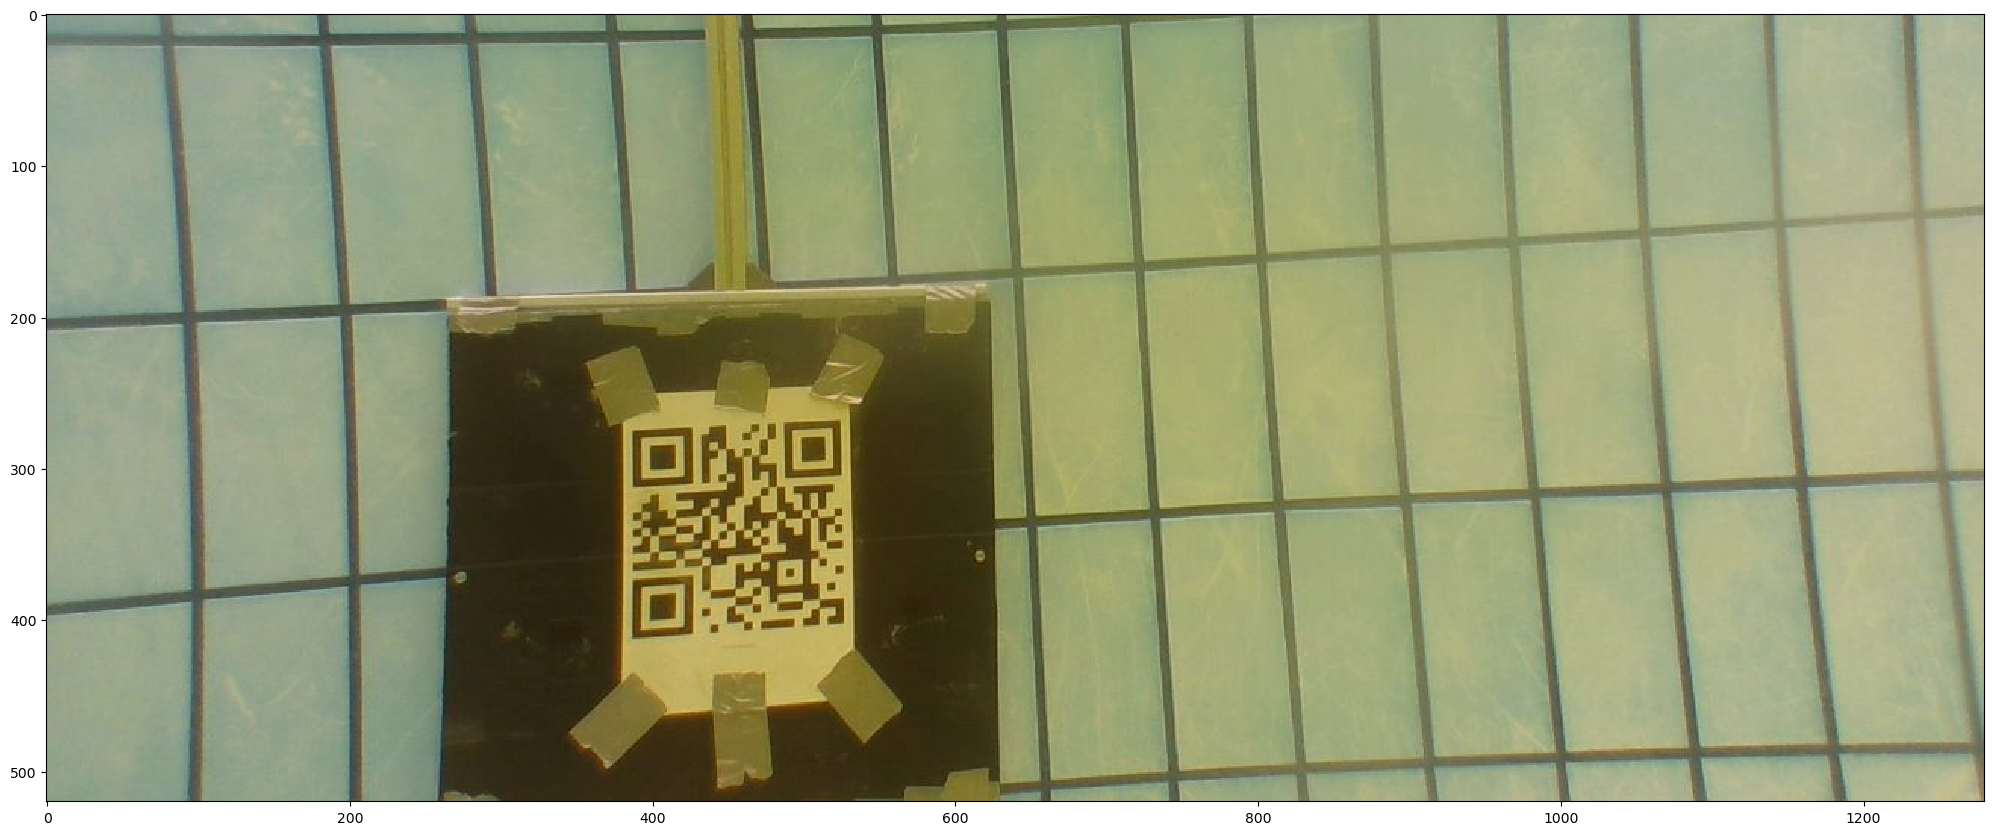

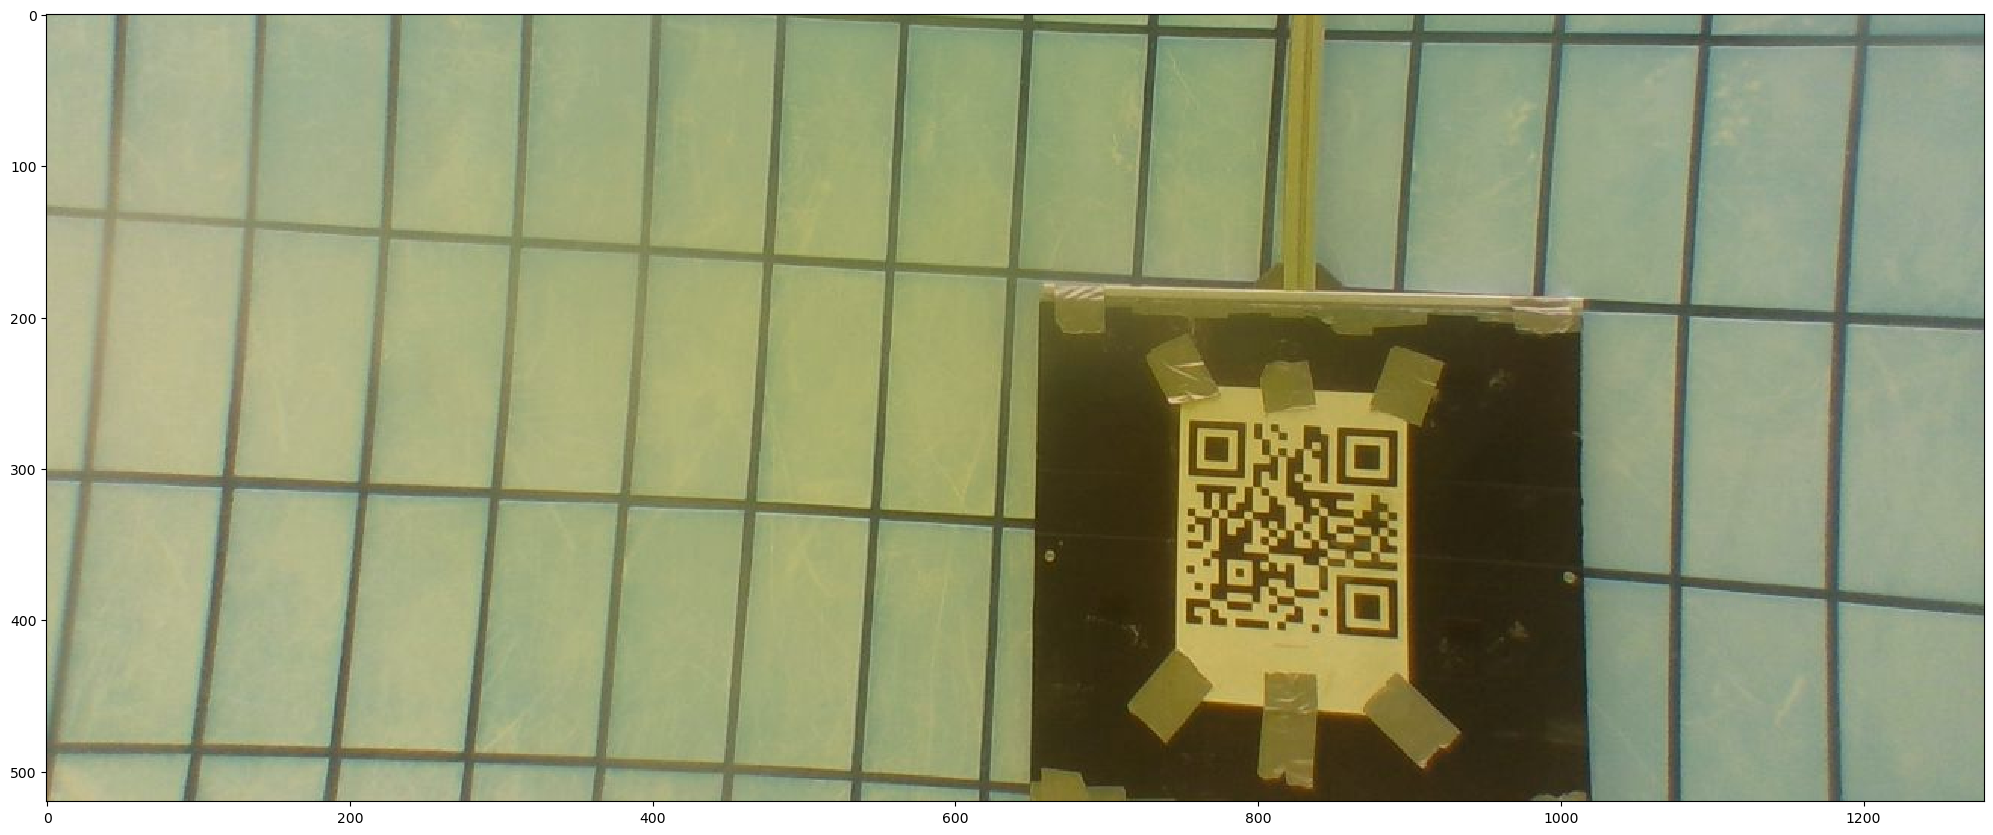

In [46]:
ref_image=cv2.imread("/home/uwr/Desktop/ref_image.png")
plt.figure(figsize=(25,15))
plt.imshow(ref_image[200:800,:])
plt.figure(figsize=(25,15))
image = cv2.flip(ref_image[200:800,:], 1) 
plt.imshow(image)

In [70]:
percentage_list=np.linspace(0.25,0.75,3)
percentage_list
distance_list=np.linspace(0.1,0.25,3)
os.makedirs("/home/uwr/Desktop/"+str(i)+"_data/",exist_ok=True)
cv2.imwrite("/home/uwr/Desktop/"+str(i)+"_data/ref_image.png",image)
psnr_list=[]
ssim_list=[]
nrmse_list=[]
hd_list=[]
nmi_list=[]
img_list=[]
for percentage in percentage_list:
    for distance in distance_list:
        print(distance,percentage)
        mosaic=image_mosaic(percentage,distance)
        ssim,psnr,hd,nrmse,nmi=img_metrics(mosaic,image)
        psnr_list.append(psnr)
        ssim_list.append(ssim)
        hd_list.append(hd)
        nrmse_list.append(nrmse)
        nmi_list.append(nmi)
        img_list.append(mosaic)
        cv2.imwrite("/home/uwr/Desktop/"+str(i)+"_data/"+str((1-percentage)*100)+"%"+str(distance)+"m_image.png",mosaic[:,:])


0.1 0.25
[(0, 53), (1, 53), (2, 53), (3, 53), (4, 54), (5, 55), (6, 54), (7, 55), (8, 55), (9, 57), (10, 57), (11, 57), (12, 57), (13, 57), (14, 57), (15, 57), (16, 57), (17, 57), (18, 57), (19, 57), (20, 57), (21, 57), (22, 57), (23, 57), (24, 57), (25, 57), (26, 57), (27, 57), (28, 57), (29, 57), (30, 57), (31, 57), (32, 57), (33, 57), (34, 57), (35, 57), (36, 86), (37, 86), (38, 87), (39, 88), (40, 88), (41, 90), (42, 91), (43, 91), (44, 93), (45, 94), (46, 94), (47, 94), (48, 96), (49, 97), (50, 97), (51, 98), (52, 98), (53, 98), (54, 99), (55, 99), (56, 99), (57, 139), (58, 99), (59, 99), (60, 99), (61, 99), (62, 99), (63, 99), (64, 99), (65, 99), (66, 99), (67, 99), (68, 99), (69, 99), (70, 99), (71, 99), (72, 99), (73, 99), (74, 99), (75, 99), (76, 99), (77, 99), (78, 99), (79, 132), (80, 133), (81, 134), (82, 136), (83, 136), (84, 138), (85, 139), (86, 141), (87, 142), (88, 144), (89, 144), (90, 145), (91, 148), (92, 148), (93, 148), (94, 151), (95, 151), (96, 151), (97, 154), 

In [30]:
cv2.imwrite("/home/uwr/Desktop/"+str(i)+"_data/best_image.png",img_list[(np.argmin(np.array(nrmse_list)))])
cv2.imwrite("/home/uwr/Desktop/"+str(i)+"_data/best_image_cropped.png",img_list[(np.argmin(np.array(nrmse_list)))][100:400,:])

True

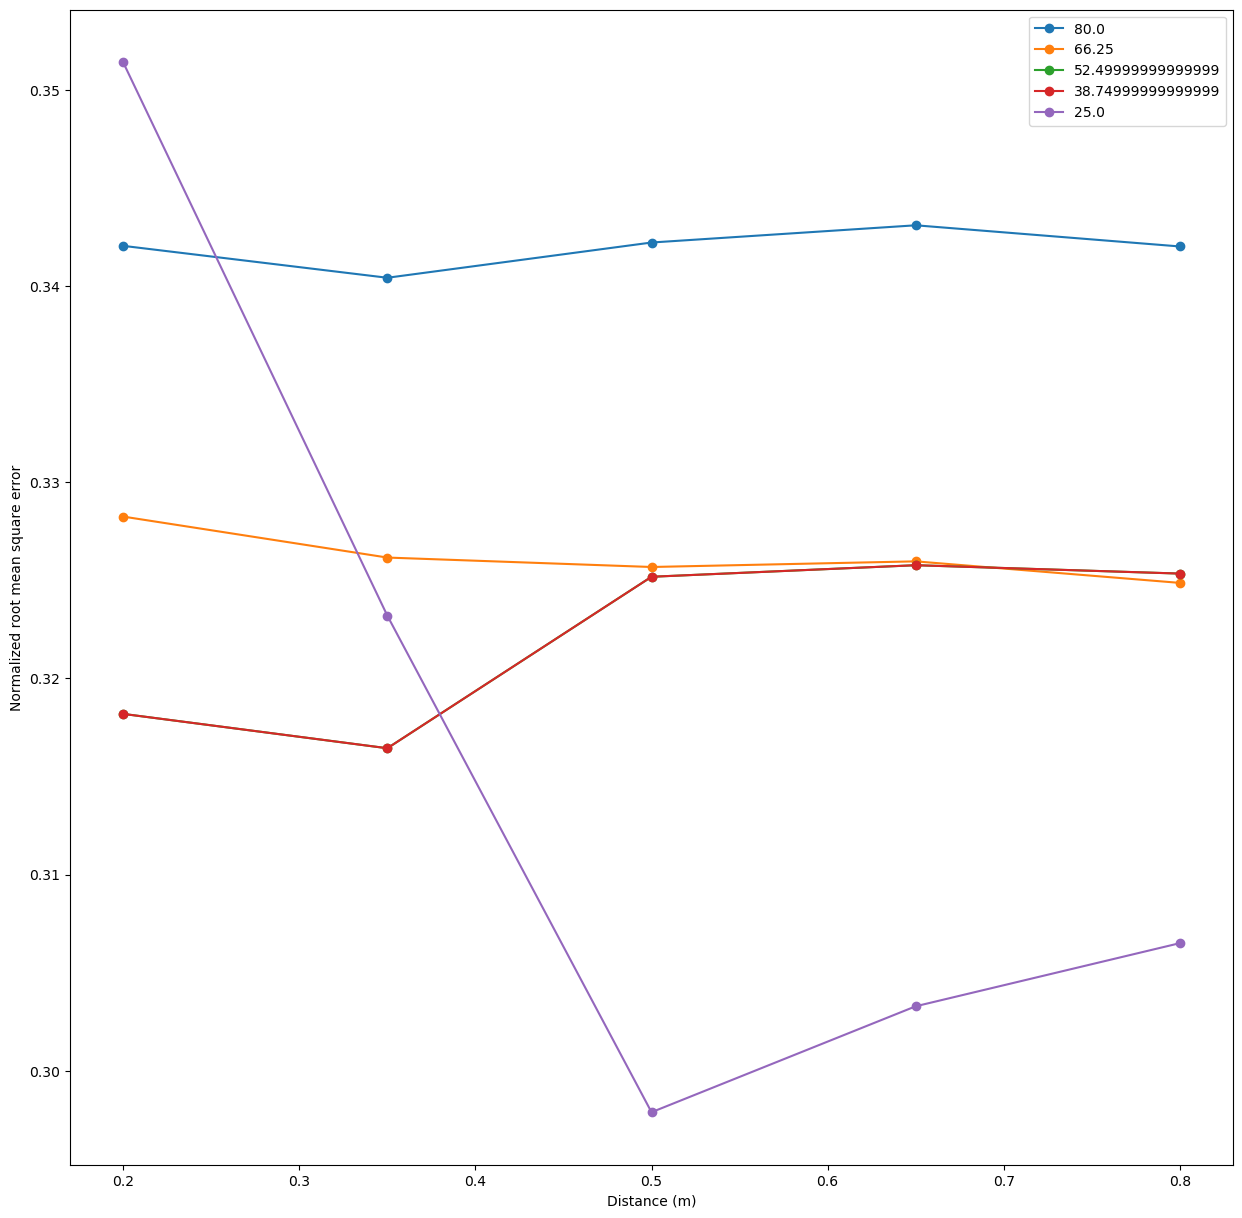

In [28]:
plt.figure(figsize=(15,15))
plt.xlabel("Distance (m)")
plt.ylabel("Normalized root mean square error")
for x in range(0,len(nrmse_list),5):
    plt.plot(distance_list,nrmse_list[x:x+5],"-o")
plt.legend((1-percentage_list)*100)

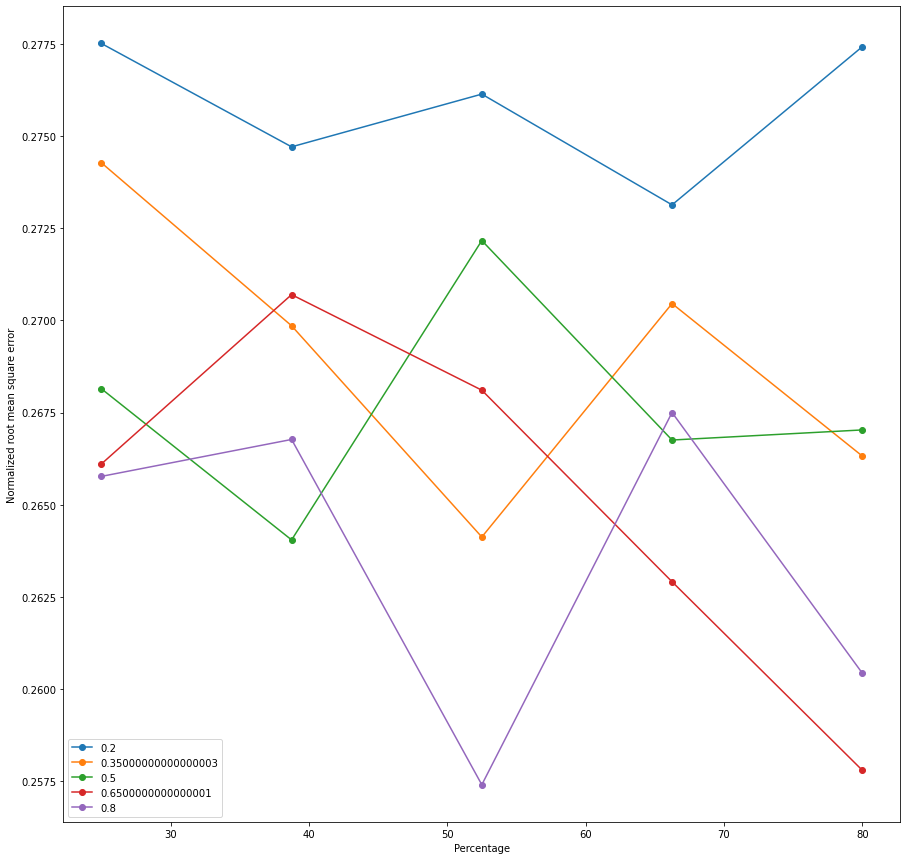

In [245]:
plt.figure(figsize=(15,15))
plt.xlabel("Percentage")
plt.ylabel("Normalized root mean square error")
for x in range(0,5):
    sample_list=np.array([0,5,10,15,20])+x
    final_list=[nrmse_list[y] for y in sample_list]
    plt.plot((1-percentage_list)*100,final_list,"-o")
plt.legend(distance_list)

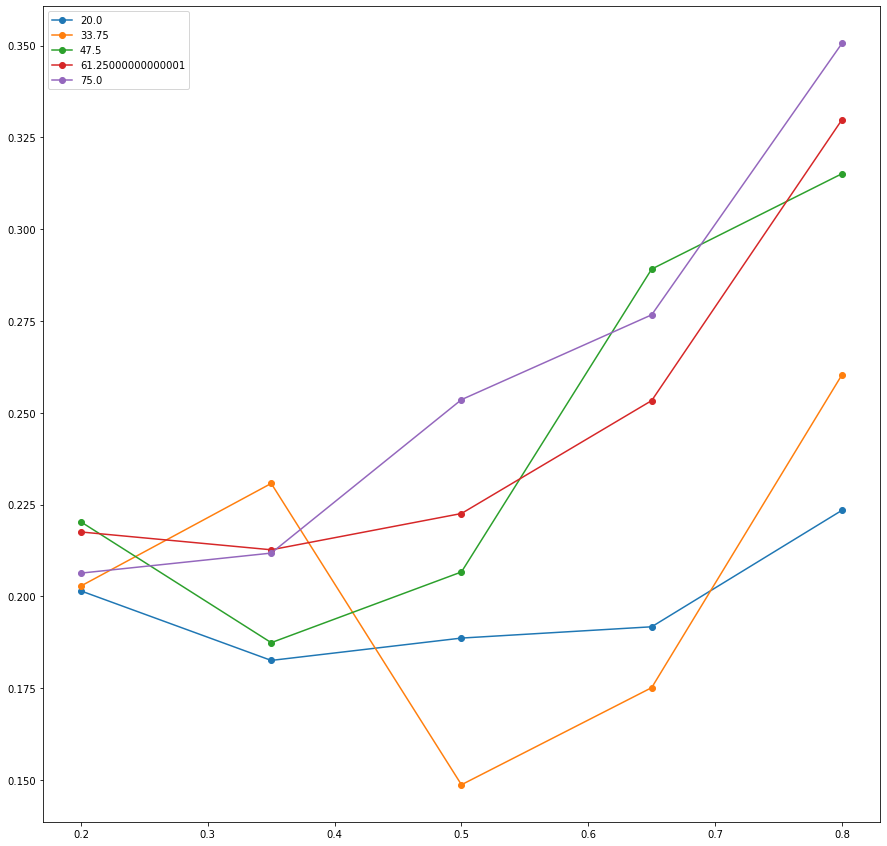

In [263]:
plt.figure(figsize=(15,15))
for x in range(0,len(ssim_list),5):
    
    plt.plot(distance_list,ssim_list[x:x+5],"-o")

plt.legend(percentage_list*100)

23

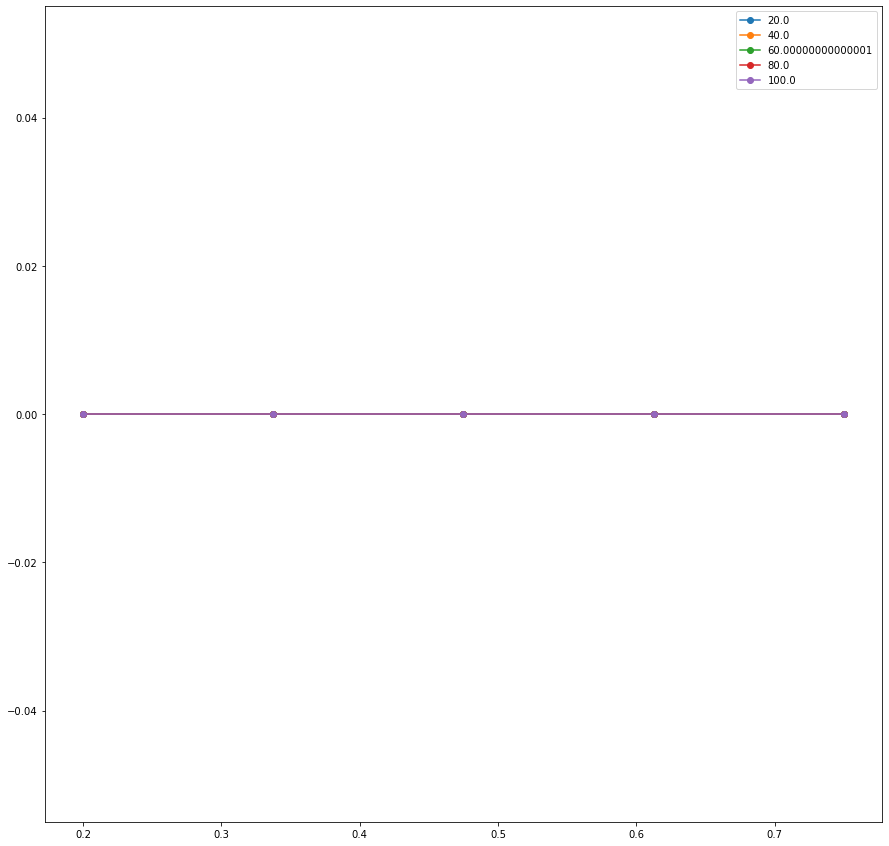

In [172]:
plt.figure(figsize=(15,15))
for x in range(0,len(hd_list),5):
    plt.plot(distance_list,hd_list[x:x+5],"-o")
plt.legend(percentage_list*100)

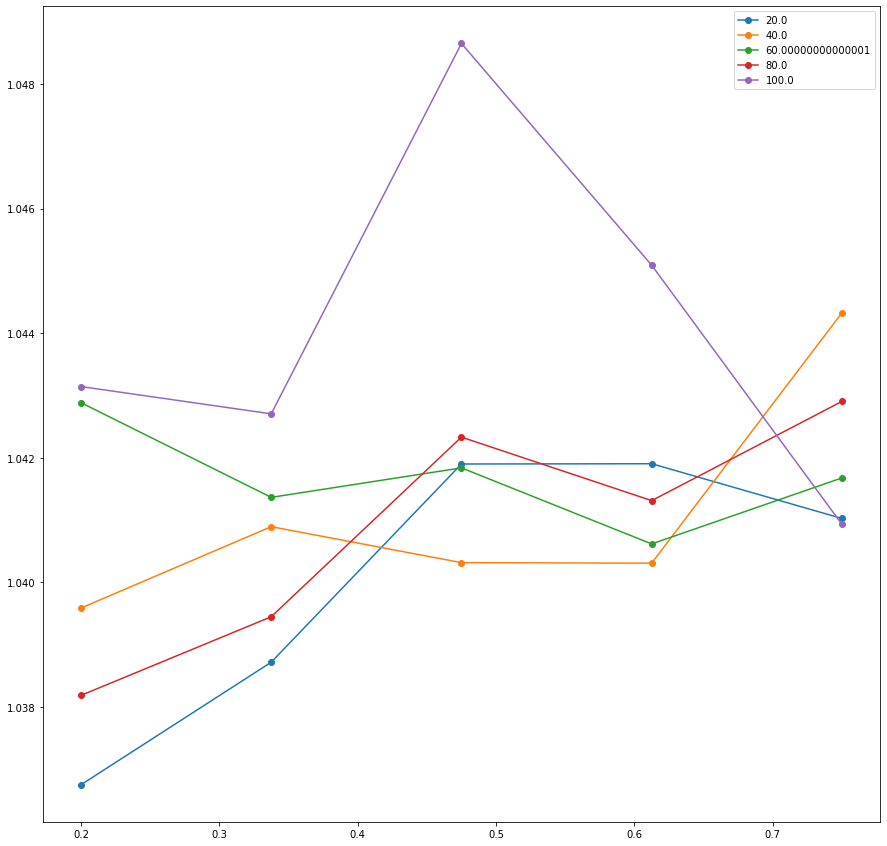

In [173]:

plt.figure(figsize=(15,15))
for x in range(0,len(nmi_list),5):
    plt.plot(distance_list,nmi_list[x:x+5],"-o")
plt.legend(percentage_list*100)

In [180]:
percentage_list

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [119]:
percentage_list[x//5]*100

100.0

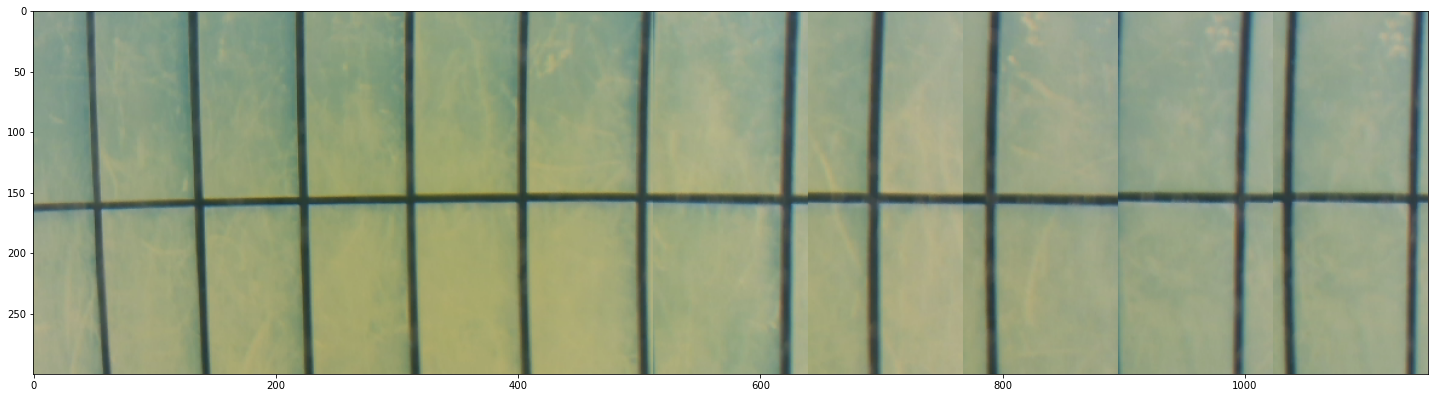

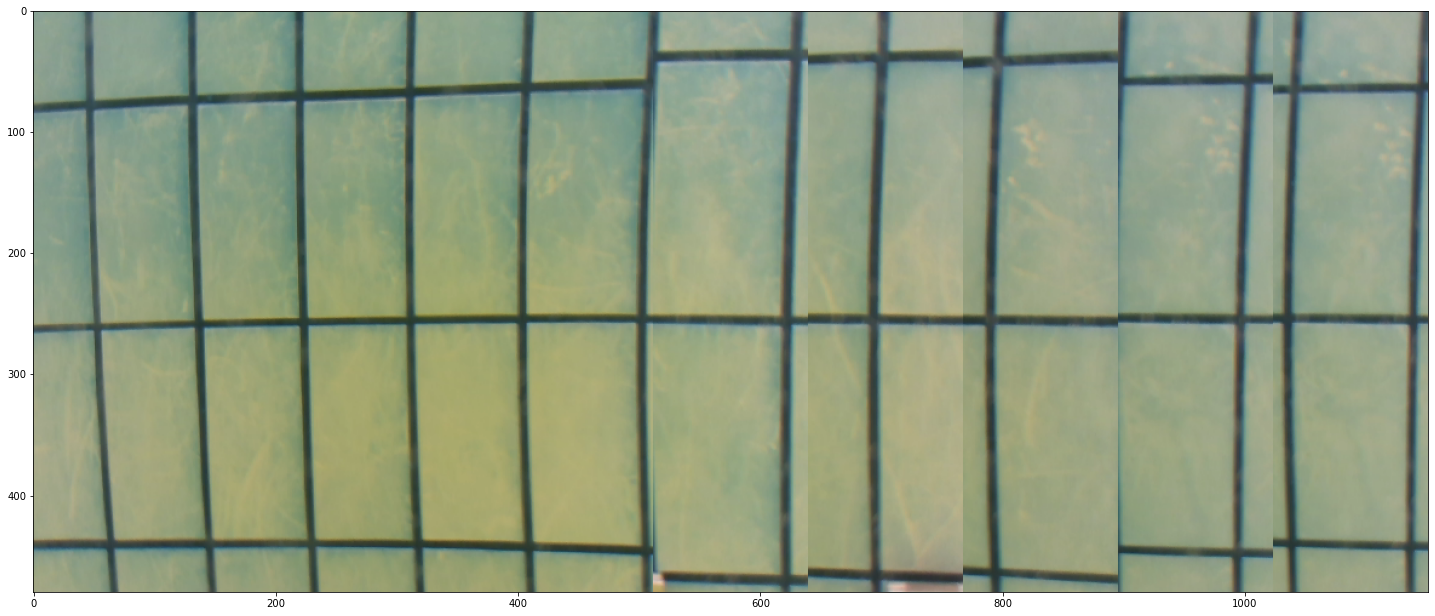

In [81]:
plt.figure(figsize=(25,15))
plt.imshow(img_first[100:400,:])

plt.figure(figsize=(25,15))
plt.imshow(img_first)

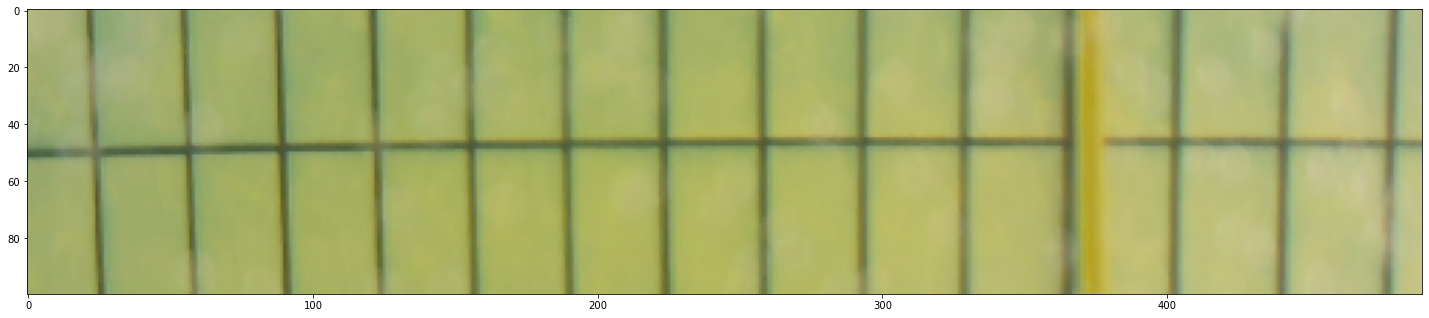

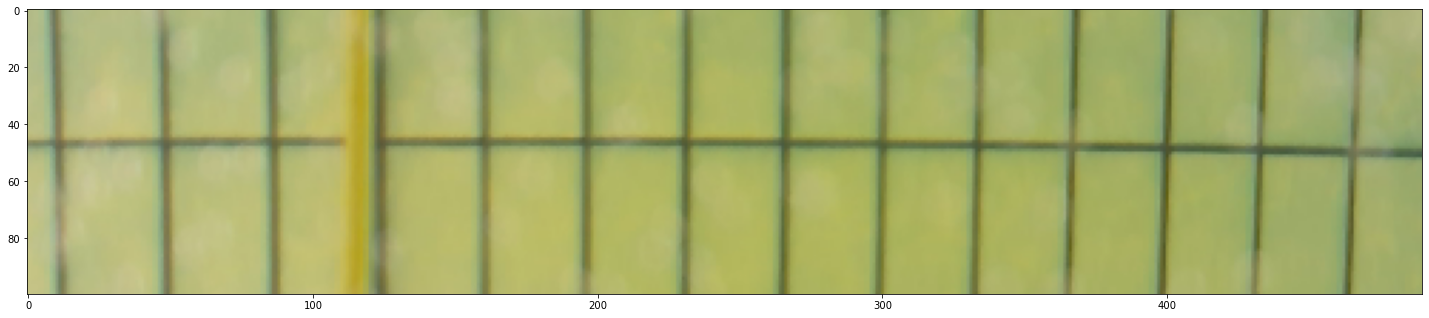

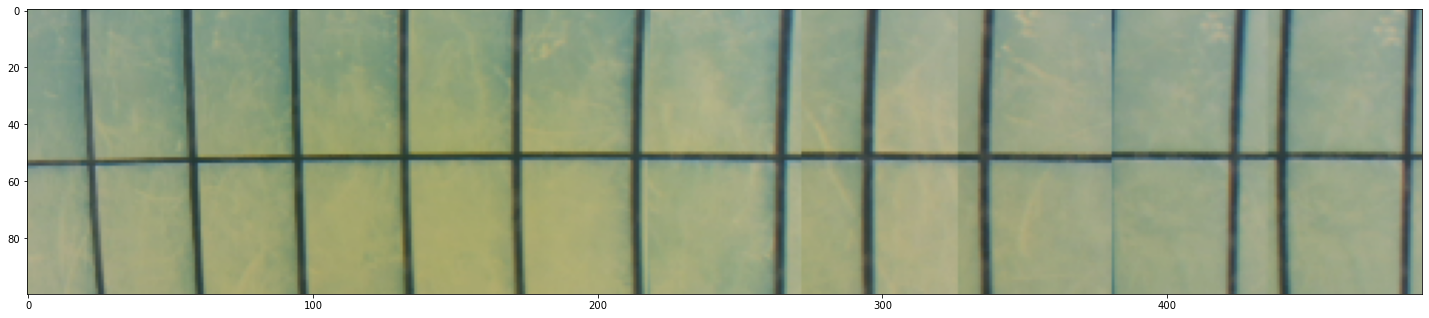

In [83]:
im1=cv2.resize(img_first[100:400,:],(image.shape[1],image.shape[0]))
plt.figure(figsize=(25,15))
plt.imshow(im1)

For image  3  Percentage:  40.0 Distance:  0.75
ssim: 0.39114512206777996
psnr: 16.590000790547514
nrmse:  0.24931077739567542
hausdorff distance: 0.0
nmi: 1.0418060542756782


In [52]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

For image  3  Percentage:  40.0 Distance:  0.5
ssim: 0.32582574766487316
psnr: 16.613066379508183
nrmse:  0.24864960489489485
hausdorff distance: 0.0
nmi: 1.0435578506509418


In [59]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

For image  3  Percentage:  40.0 Distance:  0.25
ssim: 0.23468048996304303
psnr: 16.580635307080463
nrmse:  0.24957973950721155
hausdorff distance: 0.0
nmi: 1.043369384162969


In [65]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

For image  3  Percentage:  60.0 Distance:  0.25
ssim: 0.26832049654825885
psnr: 16.60696887409848
nrmse:  0.2488242185114172
hausdorff distance: 0.0
nmi: 1.0428908327932889


In [72]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

For image  3  Percentage:  60.0 Distance:  0.5
ssim: 0.374465152603965
psnr: 16.63847287399954
nrmse:  0.24792335981103217
hausdorff distance: 0.0
nmi: 1.0429172230776393


In [79]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

For image  3  Percentage:  60.0 Distance:  0.75
ssim: 0.3696359433263954
psnr: 16.423896971355145
nrmse:  0.25412432839250976
hausdorff distance: 0.0
nmi: 1.0418948960523997


In [84]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

For image  3  Percentage:  80.0 Distance:  0.75
ssim: 0.420803764256189
psnr: 16.56788053187726
nrmse:  0.2499465035382283
hausdorff distance: 0.0
nmi: 1.0433607620848437


In [ ]:
val,img_ssim=structural_similarity(image,im1,channel_axis=2,gaussian_weights=True,full=True,data_range=255)
print("For image ",i," Percentage: ",percentage*100,"Distance: ",min_dist)
print("ssim:",val)
print("psnr:",peak_signal_noise_ratio(image,im1))
print("nrmse: ",normalized_root_mse(image,im1))
print("hausdorff distance:",hausdorff_distance(image,im1))
print("nmi:",normalized_mutual_information(image,im1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


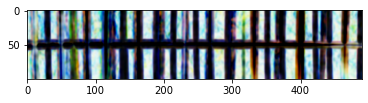

In [34]:
plt.imshow(img_ssim)

In [22]:
image.shape

(100, 490, 3)

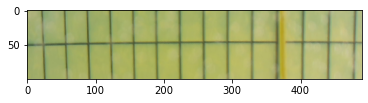

In [166]:
im2 = cv2.flip(image, 1)
plt.imshow(im2)

In [168]:

hausdorff_distance(ref_image,img_first)

1536.0

In [169]:
!pip install scikit-image --upgrade

     |████████████████████████████████| 14.7 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 36.6 MB 88 kB/s  eta 0:00:01
     |████████████████████████████████| 223 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 712 kB/s eta 0:00:01
     |████████████████████████████████| 313 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.9 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2021.7.2
    Uninstalling tifffile-2021.7.2:
      Successfully uninstalled tifffile-2021.7.2
  Attempting uninstall: scipy
    Found existing 

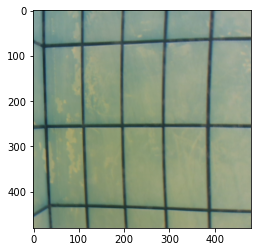

In [107]:
img_last=cv2.imread(images_list[-1])
plt.imshow(img_last[:,640//4:])
#print(img_last[:,:500])

In [108]:
camera_timestamps

array([1.70053564e+09, 1.70053565e+09, 1.70053565e+09, 1.70053565e+09,
       1.70053565e+09, 1.70053565e+09, 1.70053565e+09, 1.70053565e+09,
       1.70053565e+09, 1.70053565e+09, 1.70053565e+09, 1.70053566e+09,
       1.70053566e+09, 1.70053566e+09, 1.70053566e+09, 1.70053566e+09,
       1.70053566e+09, 1.70053566e+09, 1.70053566e+09, 1.70053566e+09,
       1.70053566e+09, 1.70053567e+09, 1.70053567e+09, 1.70053567e+09,
       1.70053567e+09, 1.70053567e+09, 1.70053567e+09, 1.70053567e+09,
       1.70053567e+09, 1.70053567e+09, 1.70053567e+09, 1.70053568e+09,
       1.70053568e+09, 1.70053568e+09, 1.70053568e+09, 1.70053568e+09,
       1.70053568e+09, 1.70053568e+09, 1.70053568e+09, 1.70053568e+09,
       1.70053568e+09, 1.70053569e+09, 1.70053569e+09, 1.70053569e+09,
       1.70053569e+09, 1.70053569e+09, 1.70053569e+09, 1.70053569e+09,
       1.70053569e+09, 1.70053569e+09, 1.70053569e+09, 1.70053570e+09,
       1.70053570e+09, 1.70053570e+09, 1.70053570e+09, 1.70053570e+09,
      

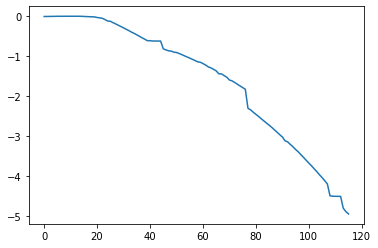

In [109]:
plt.plot(z_d)

In [87]:
l2=[]
for i in range(len(df)):
    l3=[]
    for j in range(i,len(df)):
        if(df.iloc[j]["Pose_Z"]-df.iloc[i]["Pose_Z"]>1):
            l3.append(j)
    if(len(l3)!=0):
        l2.append((i,l3[len(l3)//2]))

In [117]:
a=np.array(df.iloc[:]["Pose_Z"][:99])
c=np.unique(a)
c

array([-5.91416434e-04, -4.77743553e-04, -3.69961341e-04, -2.66794502e-05,
       -8.52871324e-12, -1.43327642e-12, -7.15769397e-13, -5.96490495e-13,
       -1.05190955e-14,  1.36573528e-12,  1.54371690e-12,  2.07993506e-12,
        2.74376235e-12,  4.39796841e-12,  6.70508315e-12,  1.35693866e-11,
        8.56274444e-08,  3.38241127e-05,  3.68642686e-05,  3.81949369e-05,
        4.03782821e-05,  4.18102371e-05,  4.93207762e-05,  5.63028837e-05,
        6.98304112e-05,  1.54583879e-04,  3.49602581e-04,  6.66666652e-01,
        9.99080551e-01,  9.99743674e-01,  9.99748807e-01,  9.99750644e-01,
        9.99786625e-01,  9.99884676e-01,  9.99974303e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  

In [103]:
t_vec_2d = np.array([np.array([df.iloc[i]["Pose_Z"],df.iloc[i]["Pose_Y"],1]) for i in lst])
K=np.array([[645,0,640],[0,645,360],[0,0,1]])
(K@t_vec_2d.T).T

array([[ 6.40000000e+02,  3.60329858e+02,  1.00000000e+00],
       [ 6.40024636e+02,  3.61348657e+02,  1.00000000e+00],
       [ 6.40021817e+02,  3.58798750e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.56701534e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.57141345e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.58900513e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.58900512e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.59120417e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.59560188e+02,  1.00000000e+00],
       [ 6.40031812e+02,  3.60456535e+02,  1.00000000e+00],
       [ 6.40000055e+02,  3.60033327e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.59780094e+02,  1.00000000e+00],
       [ 6.40026044e+02,  3.60239381e+02,  1.00000000e+00],
       [ 6.40000000e+02,  3.58900510e+02,  1.00000000e+00],
       [ 6.39618536e+02,  3.58851337e+02,  1.00000000e+00],
       [ 6.39761375e+02,  3.62350590e+02,  1.00000000e+00],
       [ 6.39982792e+02,  3.58287344e+02

In [10]:
rotation_matrices = [np.eye(3)] * len(lst)  # Assuming the same rotation matrix for all images
translation_vectors = [np.array([df.iloc[i]["Pose_X"],df.iloc[i]["Pose_Y"],df.iloc[i]["Pose_Z"]]) for i in lst]  # Replace with actual translation vectors

def construct_extrinsic_matrix(rotation_matrix, translation_vector):
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector.reshape(-1, 1)))
    extrinsic_matrix = np.vstack((extrinsic_matrix, [0, 0, 0, 1]))
    return extrinsic_matrix

def align_images(images, extrinsic_matrices):
    aligned_images = []
    reference_matrix = np.eye(4)

    for i in range(len(images)):
        print("in")
        # Compute the relative transformation between the current image and the reference image
        relative_matrix = np.linalg.inv(extrinsic_matrices[i]) @ reference_matrix
        print(relative_matrix[:3, :])

        # Apply the relative transformation to the current image
        aligned_image = cv2.warpPerspective(images[i], relative_matrix[:3, :], (images[i].shape[1], images[i].shape[0]))

        aligned_images.append(aligned_image)

    return aligned_images

def stitch_images(images):
    # Create a stitcher object
    stitcher = cv2.Stitcher_create()

    # Set registration parameters if needed
    #stitcher.setRegistrationResol(0.6)
    #stitcher.setWaveCorrection(False)
    #stitcher.setFeaturesMatcher(cv2.detail_BestOf2NearestMatcher_create(False, 0.6))

    # Extract extrinsic matrices for each image
    extrinsic_matrices = [construct_extrinsic_matrix(rotation_matrix, translation_vector)
                          for rotation_matrix, translation_vector in zip(rotation_matrices, translation_vectors)]

    # Align images using extrinsic matrices
    aligned_images = align_images(images, extrinsic_matrices)

    # Stitch aligned images
    status, panorama = stitcher.stitch(aligned_images)

    if status == cv2.Stitcher_OK:
        plt.imshow("Panorama", panorama)
    else:
        print("Stitching failed")

# Example usage:
# Assume you have the following lists for each image



In [67]:


# Load images
images = [cv2.imread(img_path) for img_path in images_list]

# Stitch images
stitch_images(images)

in
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 1.49997058e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.02275409e-03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.12533375e-12]]


error: OpenCV(4.2.0) ../modules/imgproc/src/imgwarp.cpp:3167: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [59]:
images

[array([[[145, 151, 127],
         [145, 151, 127],
         [145, 152, 126],
         ...,
         [146, 166, 149],
         [144, 166, 149],
         [144, 166, 149]],
 
        [[144, 151, 123],
         [145, 153, 124],
         [144, 148, 122],
         ...,
         [146, 166, 147],
         [144, 166, 149],
         [144, 166, 149]],
 
        [[132, 138, 107],
         [134, 140, 110],
         [138, 144, 113],
         ...,
         [146, 166, 147],
         [144, 166, 149],
         [144, 166, 149]],
 
        ...,
 
        [[159, 157, 121],
         [159, 157, 121],
         [156, 156, 122],
         ...,
         [158, 165, 130],
         [159, 166, 131],
         [158, 165, 130]],
 
        [[157, 158, 121],
         [157, 158, 121],
         [157, 157, 123],
         ...,
         [158, 165, 130],
         [159, 166, 131],
         [158, 165, 130]],
 
        [[160, 158, 122],
         [160, 158, 122],
         [158, 157, 125],
         ...,
         [160, 165, 130],
  